The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [10]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

Then we import the covid19_inference module.

In [11]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for the Czech Republic.

In [12]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()

# extract confirmed data
bd = datetime.datetime(2020,3,7) # when cases began to increase quickly
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
total_cases = jhu.get_confirmed(country = "Czechia", begin_date= bd, end_date = ed )

In [13]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[ 12   0  10  50   3  47  48  64  45  98  68 230 139 162 125 116 158 260
 271 354 352 186 184 307 200 350 233 381 115 235 195 295 257 163  99 160
  68  52 105 217 116  57 140 154 133  99  55  86  79  52  41  59  75 103
  55  18]


For the choice of changing points, see https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_Czech_Republic
Measures in the Czech republic are quite complicated.

- 07/03 some quarantine measures
- 13/03 some closures
- 16/03 curfew
- 24/04 curfew loosened

All the parameters chosen in the following amount to a quick, naive application of the model to Czech Republic. Delays are set as for Germany.

In [14]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_quarantine = datetime.datetime(2020,3,7)
prior_date_closures =  datetime.datetime(2020,3,13)
prior_date_curfew =  datetime.datetime(2020,3,16)
prior_date_curfew_loosened =  datetime.datetime(2020,4,24)

change_points = [dict(pr_mean_date_transient = prior_date_quarantine,
                      pr_sigma_date_transient = 6, 
                      pr_median_lambda = 0.35,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_closures,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 0.3,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_curfew,
                      pr_sigma_date_transient = 3, #reduced
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_curfew_loosened,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1)]

In [15]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 10.7e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # Use this array to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.4)
    # delay as for Germany
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5


In [16]:
trace = pm.sample(model=model, tune=500, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 381.26:   7%|▋         | 13699/200000 [00:25<05:51, 529.31it/s]
Convergence achieved at 13700
INFO     [pymc3.variational.inference] Convergence achieved at 13700
Interrupted at 13,699 [6%]: Average Loss = 419.69
INFO     [pymc3.variational.inference] Interrupted at 13,699 [6%]: Average Loss = 419.69
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, mu, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_4_log, lambda_3_log, lambda_2_log, lambda_1_log, lambda_0_log]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor, delay_log, I_begin, m

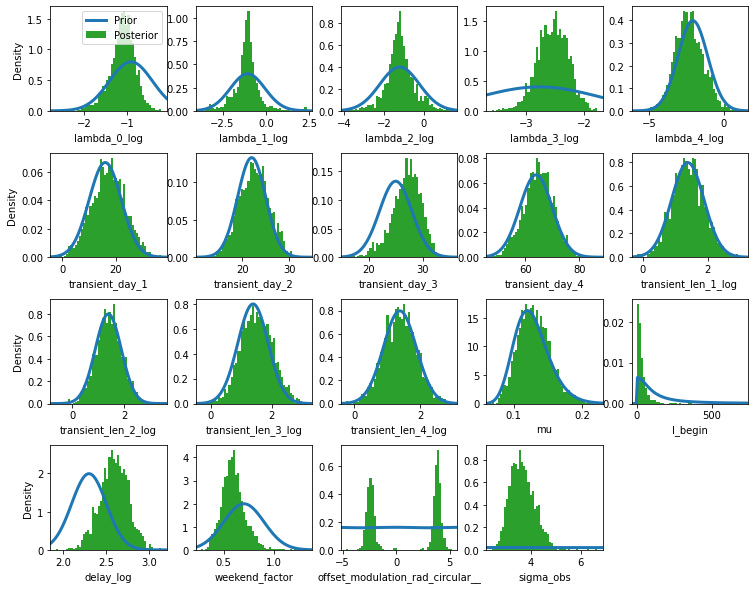

In [17]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

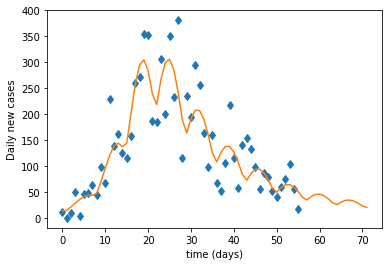

In [18]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

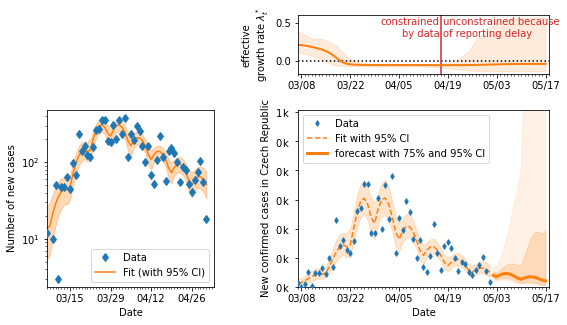

In [19]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="Czech Republic")